In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [4]:
from june.demography.geography import Geography
from june.demography.demography import load_age_and_sex_generators_for_bins, Demography, Population
from june.paths import data_path, camp_data_path
from june import World
from june.groups import Hospital, Hospitals
from june.distributors import HospitalDistributor
from june.world import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/florpi/camps/JUNE/data
No --camp_data argument given - defaulting to:
/home/florpi/camps/JUNE/camp_data
No --configs argument given - defaulting to:
/home/florpi/camps/JUNE/configs


In [5]:
area_mapping_filename = camp_data_path / "input/geography/area_super_area_region.csv"
area_coordinates_filename = camp_data_path / "input/geography/area_coordinates.csv"
super_area_coordinates_filename = (
    camp_data_path / "input/geography/super_area_coordinates.csv"
)
age_structure_filename = camp_data_path / "input/demography/age_structure_super_area.csv"
area_residents_families = camp_data_path / "input/demography/area_residents_families.csv"
area_residents_families_df = pd.read_csv(area_residents_families)
area_residents_families_df.set_index("area", inplace=True)

## Initialize the world

In [6]:
%%time
geography = Geography.from_file(
    filter_key={"region": ["CXB-219"]},
    hierarchy_filename=area_mapping_filename,
    area_coordinates_filename=area_coordinates_filename,
    super_area_coordinates_filename=super_area_coordinates_filename,
)

2020-06-10 12:21:35,189 - june.demography.geography - INFO - There are 65 areas and 4 super_areas in the world.
CPU times: user 49.2 ms, sys: 0 ns, total: 49.2 ms
Wall time: 49.2 ms


In [7]:
super_area_names = [super_area.name for super_area in geography.super_areas]
age_sex_generators = load_age_and_sex_generators_for_bins(age_structure_filename)

In [8]:
demography = Demography(
    age_sex_generators=age_sex_generators, area_names=super_area_names
)

In [9]:
world = World()
world.areas = geography.areas
world.super_areas = geography.super_areas
world.people = Population()

In [10]:
# populate area with generators from super areas
for super_area in world.super_areas:
    population = demography.populate(
        super_area.name, ethnicity=False, socioecon_index=False
    )
    np.random.shuffle(population.people)
    world.people.extend(population)
    population_super_area = len(population)
    total_residents_in_super_area = 0
    n_residents_area = []
    for area in super_area.areas:
        n_residents = area_residents_families_df.loc[area.name, "residents"]
        n_residents_area.append(n_residents)
        total_residents_in_super_area += n_residents
    for i, area in enumerate(super_area.areas):
        n_residents = min(int(np.round(n_residents_area[i] / total_residents_in_super_area * population_super_area)), len(population))
        for _ in range(n_residents):
            area.add(population.people.pop())
    if population.people:
        areas = np.random.choice(super_area.areas, size=len(population.people))
        for area in areas:
            area.add(population.people.pop())

In [11]:
hospitals= Hospitals.from_file(
    filename=camp_data_path / 'input/hospitals/hospitals.csv'
)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(hospitals, 
                                           medic_min_age=20,
                                           patients_per_medic=10)
hospital_distributor.distribute_medics_from_world(world.people)


2020-06-10 12:21:36,096 - june.groups.hospital - INFO - There are 8 hospitals in the world.


## Geography exploration

### UNHCR camp blocks inside the World

In [12]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [13]:
super_areas

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [14]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [15]:
areas[:5]

['CXB-219-062', 'CXB-219-063', 'CXB-219-061', 'CXB-219-060', 'CXB-219-065']

## Demography exploration

### UNHCR block residents

In [16]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [17]:
sample_sexes[:5], sample_ages[:5]

(['f', 'f', 'm', 'f', 'f'], [2, 52, 3, 5, 19])

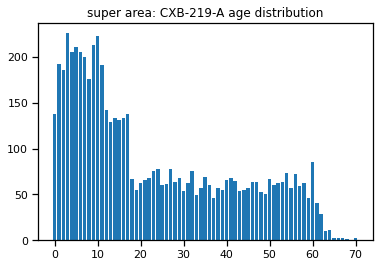

In [18]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [19]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49.0%
